In [2]:
print(f"Initialising imports......")

import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical

print(f"\nImports and Configurations Done Successfully!")

Initialising imports......

Imports and Configurations Done Successfully!


In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
CLASSES = 43

In [4]:
def create_dataframe(train_dir):
    data = []
    for class_id in range(CLASSES):
        class_path = os.path.join(train_dir, str(class_id))
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            data.append({'filepath': img_path, 'label': str(class_id)})
    df = pd.DataFrame(data)
    return df

train_dir = '/kaggle/input/gtsrb-german-traffic-sign/train'
test_csv = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'
test_img_dir = '/kaggle/input/gtsrb-german-traffic-sign'

In [5]:
df = create_dataframe(train_dir)
train_df, val_df = train_test_split(
    df, test_size=0.15, stratify=df['label'], random_state=42
)
test_df = pd.read_csv(test_csv)
test_df['filepath'] = test_df['Path'].apply(lambda x: os.path.join(test_img_dir, x))
test_df['label'] = test_df['ClassId'].astype(str)

print(f"Dataframes Created")

Dataframes Created


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_generator(datagen, dataframe, shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col='filepath',
        y_col='label',
        target_size=IMG_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

train_gen = make_generator(train_datagen, train_df)
val_gen = make_generator(val_datagen, val_df, shuffle=False)
test_gen = make_generator(test_datagen, test_df, shuffle=False)

Found 33327 validated image filenames belonging to 43 classes.
Found 5882 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [7]:
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_df['label']), y=train_df['label']
)
class_weights = {i: class_weights[i] for i in range(CLASSES)}

In [8]:
print(f"Building Model.....\n")
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)
print(f"\nModel Built Succesfully!")

Building Model.....



I0000 00:00:1749123030.682188      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749123030.682864      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Built Succesfully!


In [9]:
print(f"Initialising training....\n")
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

print(f"\nModel Trained!")

Initialising training....



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1749123089.353927     105 service.cc:148] XLA service 0x7bb9a404fdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749123089.360362     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749123089.360385     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749123091.473267     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1042 ━━━━━━━━━━━━━━━━━━━━ 8:07:22 28s/step - accuracy: 0.0000e+00 - loss: 3.0630

I0000 00:00:1749123102.156733     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 586s 536ms/step - accuracy: 0.4048 - loss: 2.0706 - val_accuracy: 0.6554 - val_loss: 1.0255 - learning_rate: 0.0010
Epoch 2/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 226s 217ms/step - accuracy: 0.6305 - loss: 1.0321 - val_accuracy: 0.7176 - val_loss: 0.8484 - learning_rate: 0.0010
Epoch 3/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 207s 199ms/step - accuracy: 0.6731 - loss: 0.8730 - val_accuracy: 0.7521 - val_loss: 0.7639 - learning_rate: 0.0010
Epoch 4/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 204s 196ms/step - accuracy: 0.6948 - loss: 0.7902 - val_accuracy: 0.7339 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 5/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 203s 195ms/step - accuracy: 0.7065 - loss: 0.7615 - val_accuracy: 0.7618 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 6/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 200s 192ms/step - accuracy: 0.7137 - loss: 0.7139 - val_accuracy: 0.7569 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 7/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 201s 193ms/step - acc

In [10]:
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights
)

print(f"Model Tuned!")

Epoch 1/15


E0000 00:00:1749127001.989914     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127002.124385     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127002.522153     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127002.659000     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 843/1042 ━━━━━━━━━━━━━━━━━━━━ 43s 217ms/step - accuracy: 0.3613 - loss: 5.9210

E0000 00:00:1749127214.280999     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127214.415027     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127214.804677     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749127214.941764     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 368s 273ms/step - accuracy: 0.3697 - loss: 5.6777 - val_accuracy: 0.5502 - val_loss: 2.1165 - learning_rate: 1.0000e-05
Epoch 2/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 226s 217ms/step - accuracy: 0.5050 - loss: 2.4639 - val_accuracy: 0.6328 - val_loss: 1.5427 - learning_rate: 1.0000e-05
Epoch 3/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 218s 209ms/step - accuracy: 0.5857 - loss: 1.5607 - val_accuracy: 0.6943 - val_loss: 1.2038 - learning_rate: 1.0000e-05
Epoch 4/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 221s 212ms/step - accuracy: 0.6475 - loss: 1.1316 - val_accuracy: 0.7336 - val_loss: 0.9581 - learning_rate: 1.0000e-05
Epoch 5/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 223s 214ms/step - accuracy: 0.6894 - loss: 0.8942 - val_accuracy: 0.7800 - val_loss: 0.7455 - learning_rate: 1.0000e-05
Epoch 6/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 218s 210ms/step - accuracy: 0.7320 - loss: 0.7238 - val_accuracy: 0.8149 - val_loss: 0.5893 - learning_rate: 1.0000e-05
Epoch 7/15
1042/1042 ━━━━━━━━━━━━━━━━━━

In [12]:
print(f"Evaluating the model....\n")
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

Evaluating the model....

395/395 ━━━━━━━━━━━━━━━━━━━━ 123s 311ms/step - accuracy: 0.8869 - loss: 0.3444

Test Accuracy: 88.38%


In [14]:
print("\n=== DEFINING CLASS LABELS ===")
classes = {
            0: 'Speed limit (20km/h)',
            1: 'Speed limit (30km/h)',
            2: 'Speed limit (50km/h)',
            3: 'Speed limit (60km/h)',
            4: 'Speed limit (70km/h)',
            5: 'Speed limit (80km/h)',
            6: 'End of speed limit (80km/h)',
            7: 'Speed limit (100km/h)',
            8: 'Speed limit (120 km/h)',
            9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'
}
print(f"Defined {len(classes)} traffic sign classes")


=== DEFINING CLASS LABELS ===
Defined 43 traffic sign classes


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: Speed limit (30km/h) (class 1) with confidence: 99.88%


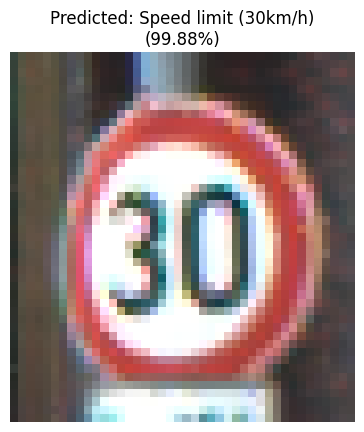

In [25]:
import matplotlib.pyplot as plt

def predict_traffic_sign(img_path):
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    img = preprocess_input(np.array(img, dtype=np.float32))
    pred = model.predict(np.expand_dims(img, axis=0))
    class_id = np.argmax(pred)
    confidence = pred[0][class_id]
    class_name = classes[class_id] 
    return class_id, class_name, confidence, img

# Example prediction
img_path = '/kaggle/input/gtsrb-german-traffic-sign/Test/00001.png'
class_id, class_name, confidence, img_array = predict_traffic_sign(img_path)
print(f"Predicted: {class_name} (class {class_id}) with confidence: {confidence:.2%}")

plt.imshow(Image.open(img_path))
plt.title(f"Predicted: {class_name}\n({confidence:.2%})")
plt.axis('off')
plt.show()
